# Waste Image Classification Model Created with Transfer Learning Method

Reference:
1. https://keras.io/guides/transfer_learning/
2. https://www.tensorflow.org/tutorials/images/transfer_learning
3. https://medium.com/@carlosz22/transfer-learning-using-keras-with-densenet-169-91679300f94a
4. https://towardsdatascience.com/17-rules-of-thumb-for-building-a-neural-network-93356f9930af
5. https://colab.research.google.com/github/https-deeplearning-ai/tensorflow-2-public/blob/adding_C2/C2/W2/assignment_optional/C2_W2_Assignment_Solution.ipynb

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf

from google.colab import files
from keras.preprocessing import image

# Data Processing

In [ ]:
# Load the data
train_dir = 'drive/MyDrive/Bangkit/training/'
validation_dir = 'drive/MyDrive/Bangkit/validation/'
print('Number of classes found in train_dir: %d' %len(os.listdir(train_dir)))
print('Number of classes found in validation_dir: %d' %len(os.listdir(validation_dir)))

Number of classes found in train_dir: 7
Number of classes found in validation_dir: 7


In [ ]:
# Generate batches of tensor image data with real-time data augmentation.
def train_val_generators(TRAINING_DIR, VALIDATION_DIR):
  train_datagen = image.ImageDataGenerator(rescale = 1/255.,
                                   rotation_range = 30,
                                   width_shift_range = 0.1,
                                   height_shift_range = 0.1,
                                   shear_range = 0.1,
                                   zoom_range = 0.1,
                                   horizontal_flip = True)

  train_generator = train_datagen.flow_from_directory(directory=TRAINING_DIR,
                                                      class_mode='categorical',
                                                      target_size=(224, 224))

  validation_datagen = image.ImageDataGenerator(rescale = 1/255.)

  validation_generator = validation_datagen.flow_from_directory(directory=VALIDATION_DIR,
                                                                class_mode='categorical',
                                                                target_size=(224, 224))
  return train_generator, validation_generator

In [ ]:
train_generator, validation_generator = train_val_generators(train_dir, validation_dir)

Found 4480 images belonging to 7 classes.
Found 1120 images belonging to 7 classes.


# Base Model

In [ ]:
# Evaluate pre-trained model architecture
base_model = tf.keras.applications.densenet.DenseNet169()
base_model.summary()

58556416/58541896 [==============================] - 0s 0us/step
Model: "densenet169"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, 230, 230, 3)  0          ['input_1[0][0]']                
                                                                                                  
 conv1/conv (Conv2D)            (None, 112, 112, 64  9408        ['zero_padding2d[0][0]']         
                                )                                                                 
                       

# Feature Extraction

In [ ]:
# Instantiate the model given inputs and outputs
input_layer = tf.keras.layers.Input(shape=(224, 224, 3))
base_model = tf.keras.applications.densenet.DenseNet169(include_top=False,
                                                        weights='imagenet',
                                                        )
x = base_model(input_layer, training=False)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
prediction_layer = tf.keras.layers.Dense(7, activation='softmax')(x)

model = tf.keras.Model(inputs=input_layer, outputs=prediction_layer)

51888128/51877672 [==============================] - 0s 0us/step


In [ ]:
# Configure the model
base_model.trainable = False
base_learning_rate = 0.0001

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss='categorical_crossentropy',
              metrics=['accuracy'])
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 densenet169 (Functional)    (None, None, None, 1664)  12642880  
                                                                 
 global_average_pooling2d (G  (None, 1664)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 7)                 11655     
                                                                 
Total params: 12,654,535
Trainable params: 11,655
Non-trainable params: 12,642,880
_________________________________________________________________


In [ ]:
# Train the model
mycallback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)
initial_epochs = 30

history = model.fit(train_generator,
                    epochs=initial_epochs,
                    validation_data=validation_generator,
                    callbacks=mycallback)

Epoch 1/30
140/140 [==============================] - 1359s 10s/step - loss: 1.6670 - accuracy: 0.3828 - val_loss: 1.3293 - val_accuracy: 0.5429
Epoch 2/30
140/140 [==============================] - 85s 610ms/step - loss: 1.1218 - accuracy: 0.6511 - val_loss: 0.9651 - val_accuracy: 0.6795
Epoch 3/30
140/140 [==============================] - 84s 596ms/step - loss: 0.8578 - accuracy: 0.7507 - val_loss: 0.7807 - val_accuracy: 0.7402
Epoch 4/30
140/140 [==============================] - 84s 599ms/step - loss: 0.7070 - accuracy: 0.7980 - val_loss: 0.6689 - val_accuracy: 0.7643
Epoch 5/30
140/140 [==============================] - 85s 605ms/step - loss: 0.6116 - accuracy: 0.8196 - val_loss: 0.5950 - val_accuracy: 0.7875
Epoch 6/30
140/140 [==============================] - 85s 611ms/step - loss: 0.5525 - accuracy: 0.8382 - val_loss: 0.5424 - val_accuracy: 0.8107
Epoch 7/30
140/140 [==============================] - 84s 599ms/step - loss: 0.4969 - accuracy: 0.8571 - val_loss: 0.5023 - val_ac

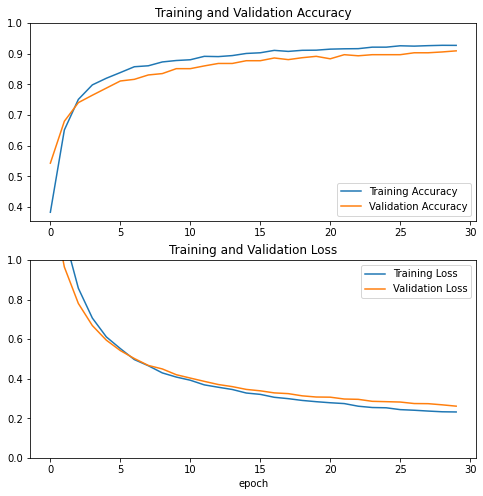

In [ ]:
# Visualize learning curve
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

# Fine Tuning

In [ ]:
# Unfreeze the base_model
base_model.trainable = True

In [ ]:
# Set only the last block of layers in base_model to be trainable
for layer in base_model.layers:
  if 'conv5' in layer.name:
    layer.trainable = True
  else:
    layer.trainable = False

model.compile(optimizer = tf.keras.optimizers.RMSprop(learning_rate=base_learning_rate/10),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 densenet169 (Functional)    (None, None, None, 1664)  12642880  
                                                                 
 global_average_pooling2d (G  (None, 1664)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 7)                 11655     
                                                                 
Total params: 12,654,535
Trainable params: 5,925,255
Non-trainable params: 6,729,280
_________________________________________________________________


In [ ]:
# Tune in the parameter on the current model
mycallback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=1, min_delta = 0.001, verbose = 1)
fine_tune_epochs = 10
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model.fit(train_generator,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=validation_generator,
                         callbacks=[mycallback])

Epoch 30/40
140/140 [==============================] - 110s 663ms/step - loss: 0.1999 - accuracy: 0.9290 - val_loss: 0.2355 - val_accuracy: 0.9134
Epoch 31/40
140/140 [==============================] - 89s 637ms/step - loss: 0.1548 - accuracy: 0.9442 - val_loss: 0.2218 - val_accuracy: 0.9152
Epoch 32/40
140/140 [==============================] - 92s 654ms/step - loss: 0.1231 - accuracy: 0.9592 - val_loss: 0.2159 - val_accuracy: 0.9241
Epoch 33/40
140/140 [==============================] - 89s 634ms/step - loss: 0.1090 - accuracy: 0.9663 - val_loss: 0.2052 - val_accuracy: 0.9268
Epoch 34/40
140/140 [==============================] - 89s 633ms/step - loss: 0.0952 - accuracy: 0.9692 - val_loss: 0.1980 - val_accuracy: 0.9304
Epoch 35/40
140/140 [==============================] - 91s 647ms/step - loss: 0.0755 - accuracy: 0.9766 - val_loss: 0.1957 - val_accuracy: 0.9402
Epoch 36/40
140/140 [==============================] - 90s 645ms/step - loss: 0.0673 - accuracy: 0.9797 - val_loss: 0.2178 

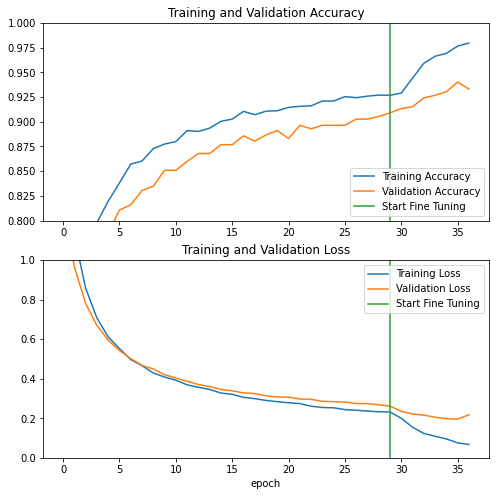

In [ ]:
# Visualize learning curve
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.8, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [ ]:
# Saving current model with .h5 format
model.save("model_bangkit_v1.h5")

In [ ]:
# Saving current model with SavedModel format
model.save("model_bangkit_v1")

INFO:tensorflow:Assets written to: model_bangkit_v1/assets


In [ ]:
!zip -r ./zipped_files/model_bangkit_v1.zip ./model_bangkit_v1

  adding: model_bangkit_v1/ (stored 0%)
  adding: model_bangkit_v1/assets/ (stored 0%)
  adding: model_bangkit_v1/keras_metadata.pb (deflated 96%)
  adding: model_bangkit_v1/variables/ (stored 0%)
  adding: model_bangkit_v1/variables/variables.data-00000-of-00001 (deflated 12%)
  adding: model_bangkit_v1/variables/variables.index (deflated 80%)
  adding: model_bangkit_v1/saved_model.pb (deflated 92%)


In [ ]:
files.download('./zipped_files/model_bangkit_v1.zip')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# Experiment - Adding dropout layer

In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 densenet169 (Functional)    (None, None, None, 1664)  12642880  
                                                                 
 global_average_pooling2d (G  (None, 1664)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 7)                 11655     
                                                                 
Total params: 12,654,535
Trainable params: 5,925,255
Non-trainable params: 6,729,280
_________________________________________________________________


In [ ]:
# Create new model based on the previous one
x = tf.keras.layers.Dropout(0.5)(model.layers[-2].output) # add dropout layer to handle overfitting
x = tf.keras.layers.Dense(7, activation='softmax')(x)

model_2 = tf.keras.Model(inputs=input_layer,outputs=x)
model_2.summary()

Model: "model_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 densenet169 (Functional)    (None, None, None, 1664)  12642880  
                                                                 
 global_average_pooling2d (G  (None, 1664)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout_17 (Dropout)        (None, 1664)              0         
                                                                 
 dense_14 (Dense)            (None, 7)                 11655     
                                                                 
Total params: 12,654,535
Trainable params: 5,925,255
Non-trainable params: 6,729,280
________________________________________

In [ ]:
# Configure the model
base_learning_rate = 0.0001

model_2.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss='categorical_crossentropy',
              metrics=['accuracy'])
model_2.summary()

Model: "model_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 densenet169 (Functional)    (None, None, None, 1664)  12642880  
                                                                 
 global_average_pooling2d (G  (None, 1664)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout_17 (Dropout)        (None, 1664)              0         
                                                                 
 dense_14 (Dense)            (None, 7)                 11655     
                                                                 
Total params: 12,654,535
Trainable params: 5,925,255
Non-trainable params: 6,729,280
________________________________________

In [ ]:
# Train the model
mycallback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=2, min_delta = 0.001, verbose = 1)
initial_epochs = 30

history_fine = model_2.fit(train_generator,
                         epochs=initial_epochs,
                         validation_data=validation_generator,
                         callbacks=[mycallback])

Epoch 1/30
140/140 [==============================] - 103s 663ms/step - loss: 0.7347 - accuracy: 0.7529 - val_loss: 0.2597 - val_accuracy: 0.9107
Epoch 2/30
140/140 [==============================] - 89s 633ms/step - loss: 0.2984 - accuracy: 0.8933 - val_loss: 0.2499 - val_accuracy: 0.9045
Epoch 3/30
140/140 [==============================] - 88s 632ms/step - loss: 0.2173 - accuracy: 0.9252 - val_loss: 0.2082 - val_accuracy: 0.9250
Epoch 4/30
140/140 [==============================] - 90s 640ms/step - loss: 0.1538 - accuracy: 0.9435 - val_loss: 0.1960 - val_accuracy: 0.9321
Epoch 5/30
140/140 [==============================] - 90s 641ms/step - loss: 0.1270 - accuracy: 0.9549 - val_loss: 0.1759 - val_accuracy: 0.9464
Epoch 6/30
140/140 [==============================] - 89s 636ms/step - loss: 0.1039 - accuracy: 0.9638 - val_loss: 0.1802 - val_accuracy: 0.9464
Epoch 7/30
140/140 [==============================] - 88s 626ms/step - loss: 0.0917 - accuracy: 0.9663 - val_loss: 0.2058 - val_a

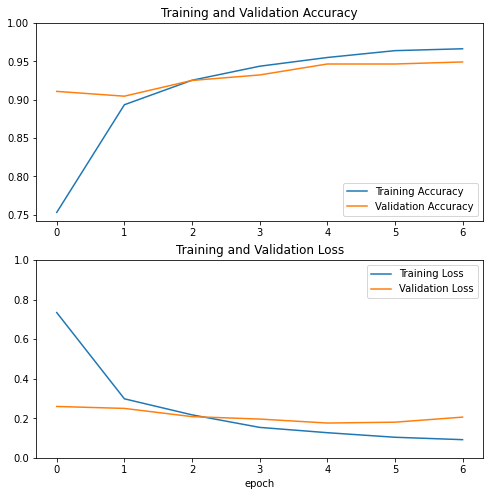

In [ ]:
# Visualize learning curve
acc = history_fine.history['accuracy']
val_acc = history_fine.history['val_accuracy']

loss = history_fine.history['loss']
val_loss = history_fine.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

# Manual Testing

In [ ]:
train_generator.class_indices

{'Elektronik': 0,
 'Kaca': 1,
 'Kertas - Karton': 2,
 'Logam': 3,
 'Plastik': 4,
 'Sisa Makanan': 5,
 'Tekstil': 6}

Saving small_kemasan_aluminium_foil_kombinasi.jpg to small_kemasan_aluminium_foil_kombinasi.jpg
small_kemasan_aluminium_foil_kombinasi.jpg
Logam


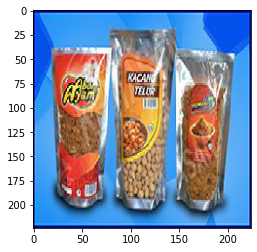

In [ ]:
uploaded = files.upload()
for fn in uploaded.keys():
  # predict images
  path = fn
  img_source = image.load_img(path, target_size = (224, 224))
  imgplot = plt.imshow(img_source)
  x = image.img_to_array(img_source)
  x = x / 225.
  x = np.expand_dims(x, axis = 0)

  test_data = np.vstack([x])
  classes = model.predict(test_data)

  print(fn)
  result = np.where(classes == np.amax(classes))
  if result[1] == 0:
    print('Elektronik')
  elif result[1] == 1:
    print('Kaca')
  elif result[1] == 2:
    print('Kertas - Karton')
  elif result[1] == 3:
    print('Logam')
  elif result[1] == 4:
    print('Plastik')
  elif result[1] == 5:
    print('Sisa Makanan')
  elif result[1] == 6:
    print('Tekstil')

# Todo! Cb lagi dengan augment 0.2

In [ ]:
# Generate batches of tensor image data with real-time data augmentation.
def train_val_generators2(TRAINING_DIR, VALIDATION_DIR):
  train_datagen = image.ImageDataGenerator(rescale = 1/255.,
                                   rotation_range = 30,
                                   width_shift_range = 0.2,
                                   height_shift_range = 0.2,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)

  train_generator = train_datagen.flow_from_directory(directory=TRAINING_DIR,
                                                      class_mode='categorical',
                                                      target_size=(224, 224))

  validation_datagen = image.ImageDataGenerator(rescale = 1/255.)

  validation_generator = validation_datagen.flow_from_directory(directory=VALIDATION_DIR,
                                                                class_mode='categorical',
                                                                target_size=(224, 224))
  return train_generator, validation_generator

In [ ]:
train_generator, validation_generator = train_val_generators(train_dir, validation_dir)

Found 4480 images belonging to 7 classes.
Found 1120 images belonging to 7 classes.


In [ ]:
# Configure the model_2
base_learning_rate = 0.0001
model_2.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=base_learning_rate/10),
              loss='categorical_crossentropy',
              metrics=['accuracy'])
model_2.summary()

Model: "model_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 densenet169 (Functional)    (None, None, None, 1664)  12642880  
                                                                 
 global_average_pooling2d (G  (None, 1664)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout_17 (Dropout)        (None, 1664)              0         
                                                                 
 dense_14 (Dense)            (None, 7)                 11655     
                                                                 
Total params: 12,654,535
Trainable params: 5,925,255
Non-trainable params: 6,729,280
________________________________________

In [ ]:
# Tune in the parameter on the current model_2
mycallback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=1, min_delta = 0.001, verbose = 1)
fine_tune_epochs = 10
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model_2.fit(train_generator,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=validation_generator,
                         callbacks=[mycallback])

Epoch 30/40
140/140 [==============================] - 108s 671ms/step - loss: 0.0440 - accuracy: 0.9862 - val_loss: 0.1917 - val_accuracy: 0.9491
Epoch 31/40
140/140 [==============================] - 89s 632ms/step - loss: 0.0312 - accuracy: 0.9879 - val_loss: 0.1971 - val_accuracy: 0.9589
Epoch 31: early stopping


# Manual Testing

Saving small_kemasan_aluminium_foil_kombinasi.jpg to small_kemasan_aluminium_foil_kombinasi.jpg
small_kemasan_aluminium_foil_kombinasi.jpg
Logam


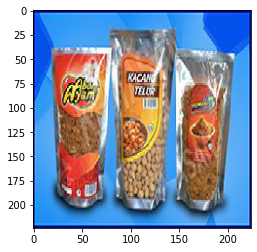

In [ ]:
uploaded = files.upload()
for fn in uploaded.keys():
  # predict images
  path = fn
  img_source = image.load_img(path, target_size = (224, 224))
  imgplot = plt.imshow(img_source)
  x = image.img_to_array(img_source)
  x = x / 225.
  x = np.expand_dims(x, axis = 0)

  test_data = np.vstack([x])
  classes = model.predict(test_data)

  print(fn)
  result = np.where(classes == np.amax(classes))
  if result[1] == 0:
    print('Elektronik')
  elif result[1] == 1:
    print('Kaca')
  elif result[1] == 2:
    print('Kertas - Karton')
  elif result[1] == 3:
    print('Logam')
  elif result[1] == 4:
    print('Plastik')
  elif result[1] == 5:
    print('Sisa Makanan')
  elif result[1] == 6:
    print('Tekstil')

In [ ]:
# Saving current model with .h5 format
model.save("model_bangkit_v2.h5")

# Saving current model with SavedModel format
model.save("model_bangkit_v2")

!zip -r ./zipped_files/model_bangkit_v2.zip ./model_bangkit_v2

files.download('./zipped_files/model_bangkit_v2.zip')

INFO:tensorflow:Assets written to: model_bangkit_v2/assets
  adding: model_bangkit_v2/ (stored 0%)
  adding: model_bangkit_v2/assets/ (stored 0%)
  adding: model_bangkit_v2/keras_metadata.pb (deflated 96%)
  adding: model_bangkit_v2/variables/ (stored 0%)
  adding: model_bangkit_v2/variables/variables.data-00000-of-00001 (deflated 7%)
  adding: model_bangkit_v2/variables/variables.index (deflated 79%)
  adding: model_bangkit_v2/saved_model.pb (deflated 92%)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>